In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import json

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
with open("../utils/columns.json", 'rb') as file:
    column_names = json.load(file)['trainTestColumns']

In [5]:
column=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [6]:
train=pd.read_csv("../data/train_FD001.txt",sep=" ",names=column)

In [7]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('engine')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['engine','max']
    df = df.merge(fd_RUL, on=['engine'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

In [8]:
test=pd.read_csv("../data/test_FD001.txt",sep=" ",names=column)
test_results=pd.read_csv("../data/RUL_FD001.txt",sep=" ",header=None)

test_results.columns=["rul","null"]
test_results.drop(["null"],axis=1,inplace=True)
test_results['id']=test_results.index+1
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

test_results['rul_failed']=test_results['rul']+rul['max']
test_results.drop(["rul"],axis=1,inplace=True)

test=test.merge(test_results,on=['id'],how='left')
test["RUL"]=test["rul_failed"]-test["cycle"]
test.drop(columns=['rul_failed'], inplace=True)

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
te_null_df = pd.DataFrame(test.isnull().sum()).T
te_null_df[te_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

,sensor22,sensor23
0,13096,13096


In [11]:
tr_null_df = pd.DataFrame(train.isnull().sum()).T
tr_null_df[tr_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

,sensor22,sensor23
0,20631,20631


In [12]:
null_cols = ["sensor22","sensor23"]

In [13]:
#Dropping null columns
df_train=train.drop(null_cols,axis=1)
df_train.columns = column_names
df_train = prepare_train_data(df_train)

df_test=test.drop(null_cols,axis=1)
df_test.columns = column_names+['RUL']

In [14]:
train_end = int(len(df_train)*0.9)

In [15]:
exo_col = [col for col in df_train.columns if col not in ['RUL']]
endo_col = ['RUL']

In [16]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train, y_train = scaler_x.fit_transform(df_train[exo_col][:train_end]), scaler_y.fit_transform(df_train[['RUL']][:train_end]) 
x_val, y_val  =  scaler_x.transform(df_train[exo_col][train_end:]), scaler_y.transform(df_train[['RUL']][train_end:])
x_test, y_test = scaler_x.transform(df_test[exo_col]), df_test[['RUL']].values

In [17]:
# # Without scaling (Splitting train and val as we do it for scaling case)
# x_train, y_train = df_train[exo_col][:train_end].values, df_train[['RUL']][:train_end].values
# x_val, y_val  =  df_train[exo_col][train_end:].values, df_train[['RUL']][train_end:].values

# x_test, y_test = df_test[exo_col].values, df_test[['RUL']].values

In [18]:
x_train.shape, y_train.shape

((18567, 26), (18567, 1))

In [19]:
# Function to create sequences
def create_sequences(data, target_col, window_size):
    X_seq, y_seq = [], []    
    for i in range(len(data) - window_size):
        X_seq.append(data.iloc[i:i+window_size].drop(columns=[target_col]).values)
        # X_seq.append(data.iloc[i:i+window_size].values)
        y_seq.append(data.iloc[i+window_size][target_col])
    return np.array(X_seq), np.array(y_seq)

In [20]:
x_train.shape

(18567, 26)

In [21]:
window_size = x_train.shape[-1] #20 #10
df_train_scaled = pd.DataFrame((np.concatenate((x_train, x_val), axis=0)), columns= exo_col)
df_train_scaled['Target'] = np.concatenate((y_train,y_val), axis= 0)
x_train_seq, y_train_seq = create_sequences(df_train_scaled, 'Target', window_size)

In [22]:
df_test_scaled = pd.DataFrame((x_test), columns= exo_col)
df_test_scaled['Target'] = y_test
x_test_seq, y_test_seq = create_sequences(df_test_scaled, 'Target', window_size)

In [23]:
import torch
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64

#Train and val data loader
X_train_tensor = torch.tensor(x_train_seq[:train_end], dtype = torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_seq[:train_end], dtype= torch.float32, device=device)

X_val_tensor = torch.tensor(x_train_seq[train_end:], dtype = torch.float32, device=device)
y_val_tensor = torch.tensor(y_train_seq[train_end:]  , dtype= torch.float32, device=device)

# test data loader
X_test_tensor = torch.tensor(x_test_seq, dtype = torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_seq, dtype= torch.float32, device=device)

traindataset = TensorDataset(X_train_tensor, y_train_tensor) 
valdataset = TensorDataset(X_val_tensor, y_val_tensor) 

train_loader = DataLoader(traindataset, batch_size=batch_size, shuffle=False) 
val_loader = DataLoader(valdataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor) 
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [24]:
def evaluate(y_true, y_pred):
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')
    print(f'r2 score: {r2_score(y_true, y_pred):.2f}')
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask for non-zero actual values
    act_non_zero_mask = y_true != 0

    # Create a mask for non-zero pred values
    pred_non_zero_mask = y_pred != 0

    # Ensure that there are non-zero actual values
    if not np.any(act_non_zero_mask):
        raise ValueError("All actual values are zero, MAPE is undefined.")
    if not np.any(pred_non_zero_mask):
        raise ValueError("All pred values are zero, MAPE will be 100%.")

    # Calculate MAPE
    non_zero_mask = np.logical_and(act_non_zero_mask, pred_non_zero_mask)
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    # abs_percentage_error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    abs_percentage_error = np.abs((y_true - y_pred) / y_true)
    mape = np.mean(abs_percentage_error) * 100
    print(f'MAPE: {mape:.2f}')

In [25]:
def plot_result(y_actual, y_pred):
    plt.figure(figsize= (20, 5))
    plt.plot(y_actual, label='actual', color = 'blue')
    plt.plot(y_pred, label= 'prediction', color='orange' )
    plt.legend()
    plt.show()

In [26]:
class EarlyStopping:
    def __init__(self, patience = 10, delta = 0):
        self.patience = patience
        self.delta = delta
        self.best_score = np.inf 
        self.early_stop = False
        self.counter = 0 

    def __call__(self, val_loss):
        score = val_loss
        if self.best_score - score > self.delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
patience = 15
early_stopping = EarlyStopping(patience=15, delta=0.01)

DeFormer model

In [27]:
from deformer_model import DEformer

# Hyperparameters
input_dim = x_train.shape[-1]        # Number of features
seq_len = x_train.shape[-1]             # Sequence length
embed_dim = 64        # Embedding dimension
num_heads = 4         # Number of attention heads
num_layers = 2        # Number of Transformer layers in each encoder
output_dim = 1        # Output dimension for forecasting

# Instantiate and test model
# model = DEformer(input_dim=16, embed_dim=64, num_heads=4, num_layers=2, output_dim=1, seq_len=20)
model = DEformer(input_dim, embed_dim, num_heads, num_layers, output_dim, seq_len)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) 
criterion = nn.MSELoss()
model_name = 'deformer'

CNN model

In [28]:
# from cnn_model import CNNModel

# hidden_dim = 128
# batch_size = 64 #32
# input_dim = x_train.shape[-1]
# kernel_size = 3
# model = CNNModel(input_dim, window_size, hidden_dim=hidden_dim,kernel_size=kernel_size, device=device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) 
# criterion = nn.MSELoss()
# model_name = 'tdcnn'

TDCNN + SEBlock

In [29]:
# from TDCNN_model import FPCASETCN

# # Example training loop with batches
# model = FPCASETCN(x_train.shape[-1], [64, 128, 256]) # Example model
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model_name = 'tdcnn_se'

In [30]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [31]:
# Training loop
train_losses = []
val_losses = []
gradient_norms = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:   
        optimizer.zero_grad()
        # if model_name == 'tdcnn_se':
        inputs = inputs.permute(0, 2, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Collect gradients norms
        norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
        gradient_norms.append(np.mean(norms))  # Store the mean norm of gradients. This ran for 1550 element (len(train_loader)) as we are taking mean than for 8 epochs.

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:  
            inputs = torch.permute(inputs, (0, 2, 1))
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Check early stopping
    early_stopping(val_loss)
    
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Update the learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.

Epoch 1/100, Train Loss: 0.9239, Val Loss: 1.5466
Epoch 2/100, Train Loss: 0.8635, Val Loss: 1.3553
Epoch 3/100, Train Loss: 0.8570, Val Loss: 1.3016
Epoch 4/100, Train Loss: 0.8581, Val Loss: 1.2093
Epoch 5/100, Train Loss: 0.8548, Val Loss: 1.1916
Epoch 6/100, Train Loss: 0.8520, Val Loss: 1.1906
Epoch 7/100, Train Loss: 0.8486, Val Loss: 1.1741
Epoch 8/100, Train Loss: 0.8438, Val Loss: 1.1596
Epoch 9/100, Train Loss: 0.8391, Val Loss: 1.1604
Epoch 10/100, Train Loss: 0.8323, Val Loss: 1.1675
Epoch 11/100, Train Loss: 0.8022, Val Loss: 1.1920
Epoch 12/100, Train Loss: 0.7981, Val Loss: 1.1833
Epoch 13/100, Train Loss: 0.7957, Val Loss: 1.1763
Epoch 14/100, Train Loss: 0.7936, Val Loss: 1.1717
Epoch 15/100, Train Loss: 0.7918, Val Loss: 1.1676
Epoch 16/100, Train Loss: 0.7917, Val Loss: 1.1644
Epoch 17/100, Train Loss: 0.7909, Val Loss: 1.1611
Epoch 18/100, Train Loss: 0.7896, Val Loss: 1.1601
Epoch 19/100, Train Loss: 0.7893, Val Loss: 1.1586
Epoch 20/100, Train Loss: 0.7886, Val Lo

In PyTorch, for a Conv1d layer, the weight shape is (out_channels, in_channels, kernel_size). 

In your model:
out_channels = 128

in_channels = 26

kernel_size = 3

So, the weight tensor shape for conv1 is (128, 26, 3).

In [32]:
def weight_importance_first_layer(model):
    first_layer_weights = next(model.parameters())  # Get weights from the first layer
    # Mean absolute weight per input feature across output channels and kernel size
    importance = first_layer_weights.abs().mean(dim=(0, 2))
    return importance  # Output shape will be (26,)

In [35]:
# importance = weight_importance_first_layer(model)
# importance

In [36]:
def predict(model, dataloader, device='cpu', model_name=None):
    model.to(device)  # Move model to the appropriate device (CPU or GPU)
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, _ in dataloader:  # Assuming dataloader returns (inputs, targets)
            if model_name == 'TDCNN':
                inputs = torch.permute(inputs, (0, 2, 1))
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu())  # Move to CPU and collect predictions
    return torch.cat(all_predictions, dim=0)  #

In [37]:
y_test_pred = predict(model, test_loader,device= device, model_name= 'TDCNN')

dformer

RMSE: 70.61
MAE: 56.25
r2 score: -0.43
MAPE: 53.72


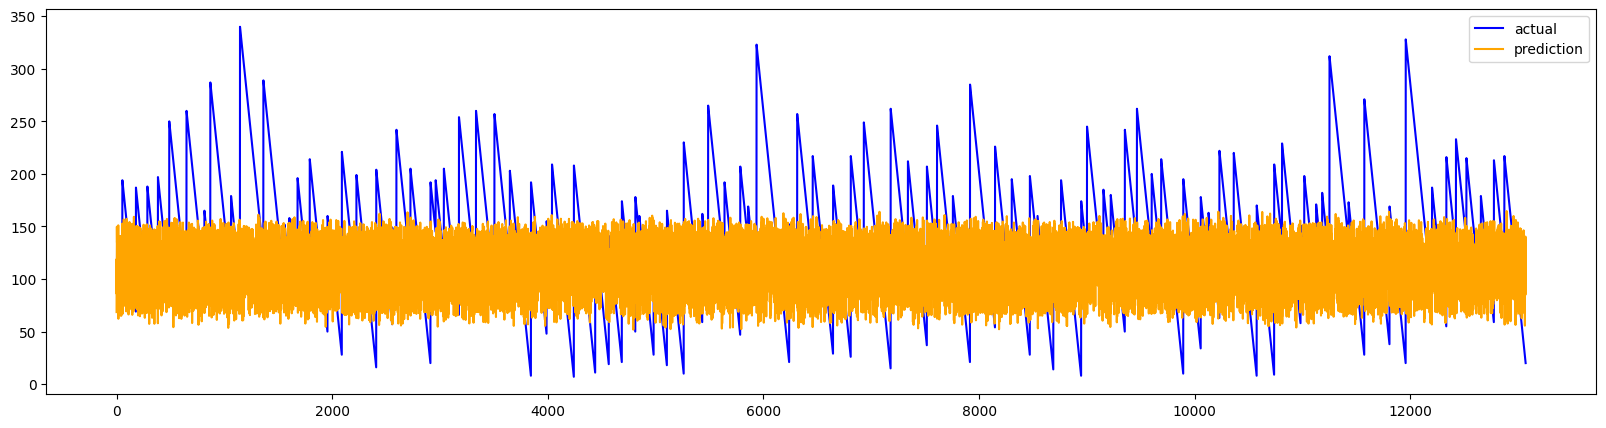

In [38]:
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

tdcnn

RMSE: 69.62
MAE: 55.00
r2 score: -0.39
MAPE: 53.67


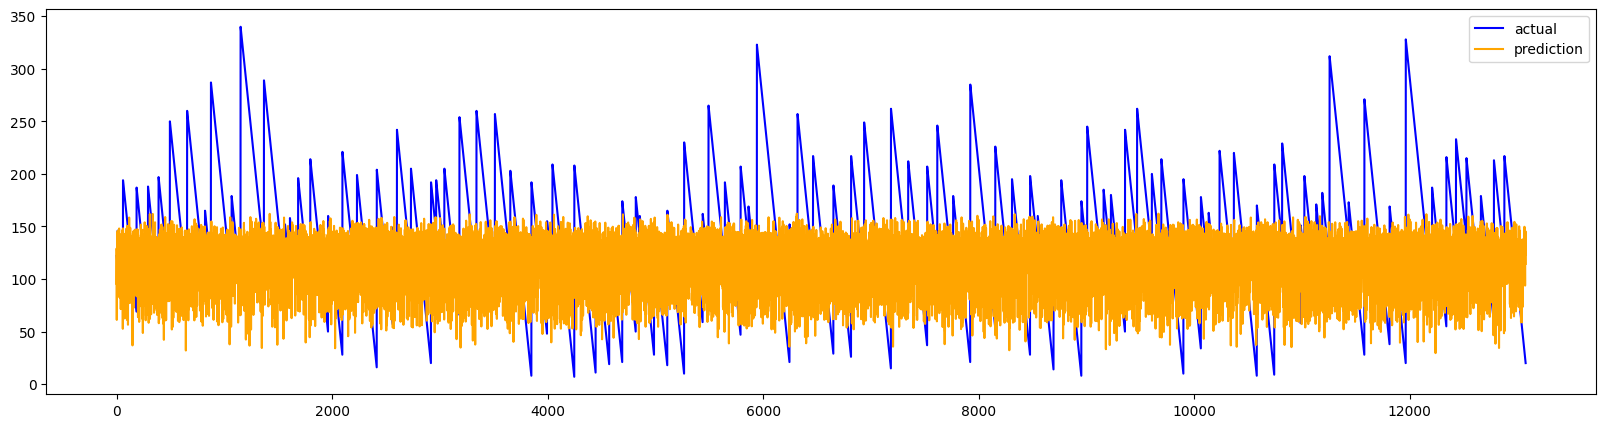

In [42]:
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

cnn

MSE: 4808.49
MAE: 55.06
r2 score: -0.38
MAPE: 53.40


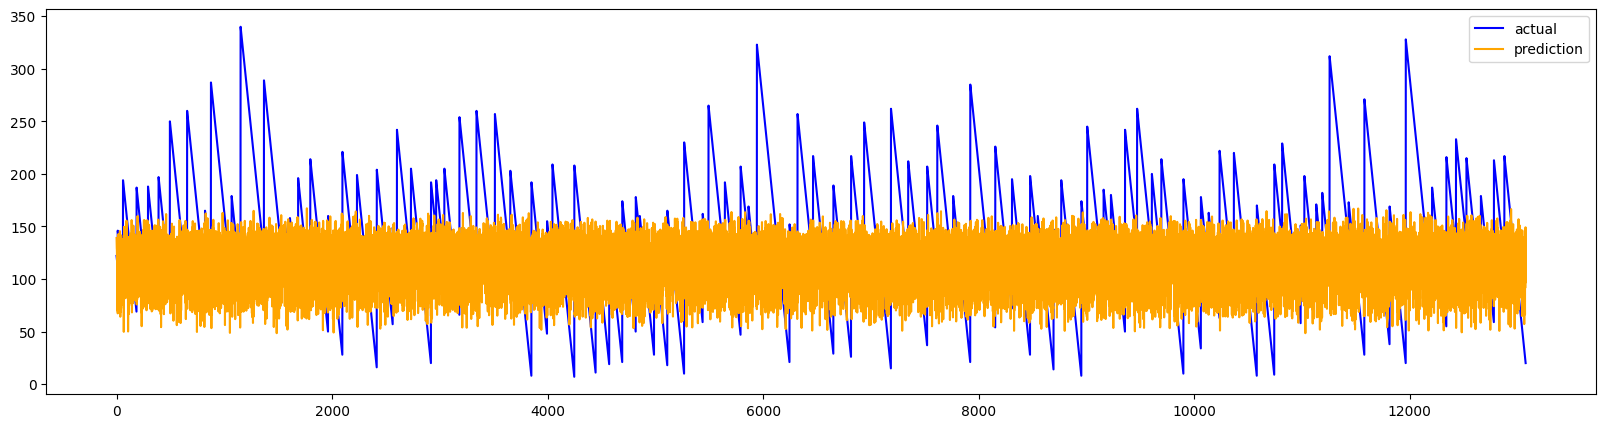

In [46]:
# y_test_inv = scaler_y.inverse_transform(y_test)
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
evaluate(y_test[window_size:], y_test_pred_inv)
plot_result(y_test[window_size:], y_test_pred_inv)

In [39]:
df_tes = pd.DataFrame({"actual": y_test[window_size:].flatten(), "Pred": y_test_pred_inv.flatten(),"Error":  y_test_pred_inv.flatten()- y_test[window_size:].flatten() })

dformer

In [40]:
df_tes

,actual,Pred,Error
0,116,68.544959,-47.455041
1,115,119.091913,4.091913
2,114,85.757556,-28.242444
3,113,149.772839,36.772839
4,112,134.855135,22.855135
...,...,...,...
13065,24,103.924902,79.924902
13066,23,125.009162,102.009162
13067,22,140.385747,118.385747
13068,21,140.258256,119.258256


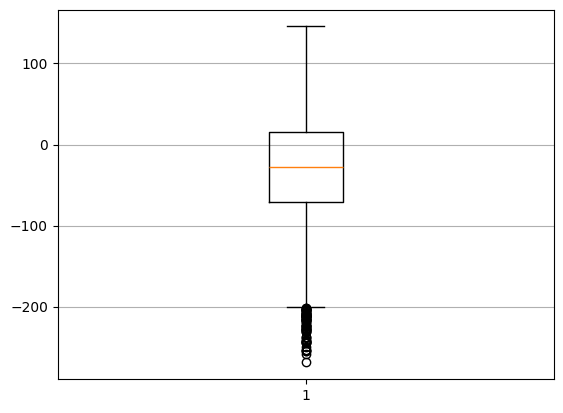

In [41]:
plt.boxplot(df_tes['Error'])
plt.grid(axis='y')
plt.show()

tdcnn

In [44]:
df_tes

,actual,Pred,Error
0,122,95.448404,-26.551596
1,121,129.151165,8.151165
2,120,61.119412,-58.880588
3,119,116.457092,-2.542908
4,118,129.063224,11.063224
...,...,...,...
13071,24,133.608497,109.608497
13072,23,122.471148,99.471148
13073,22,136.068278,114.068278
13074,21,145.386935,124.386935


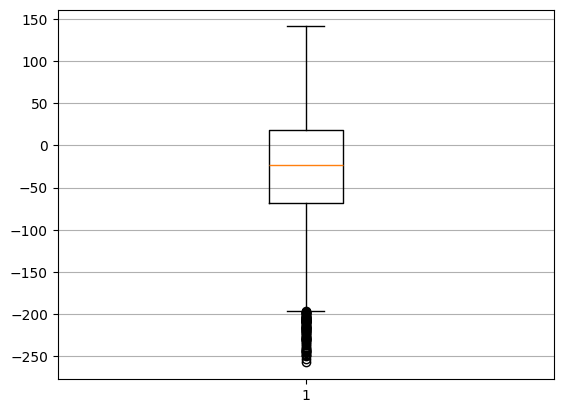

In [47]:
plt.boxplot(df_tes['Error'])
plt.grid(axis='y')
plt.show()

cnn

In [48]:
df_tes

,actual,Pred,Error
0,122,139.067835,17.067835
1,121,132.726176,11.726176
2,120,129.157213,9.157213
3,119,127.761470,8.761470
4,118,122.323172,4.323172
...,...,...,...
13071,24,91.540173,67.540173
13072,23,124.309433,101.309433
13073,22,127.633886,105.633886
13074,21,149.237432,128.237432


dformer

RMSE: 58.19
MAE: 44.75
r2 score: 0.26
MAPE: 242.18


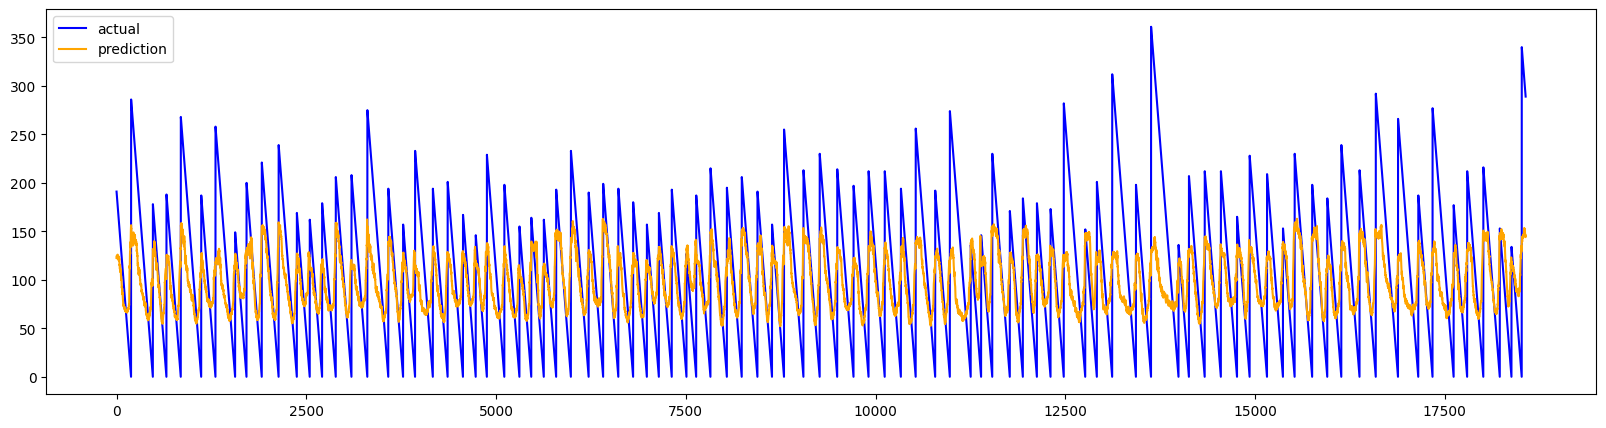

In [42]:
# y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader))
y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader,device= device, model_name= 'TDCNN'))
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

tdcnn

RMSE: 55.51
MAE: 41.19
r2 score: 0.32
MAPE: 249.30


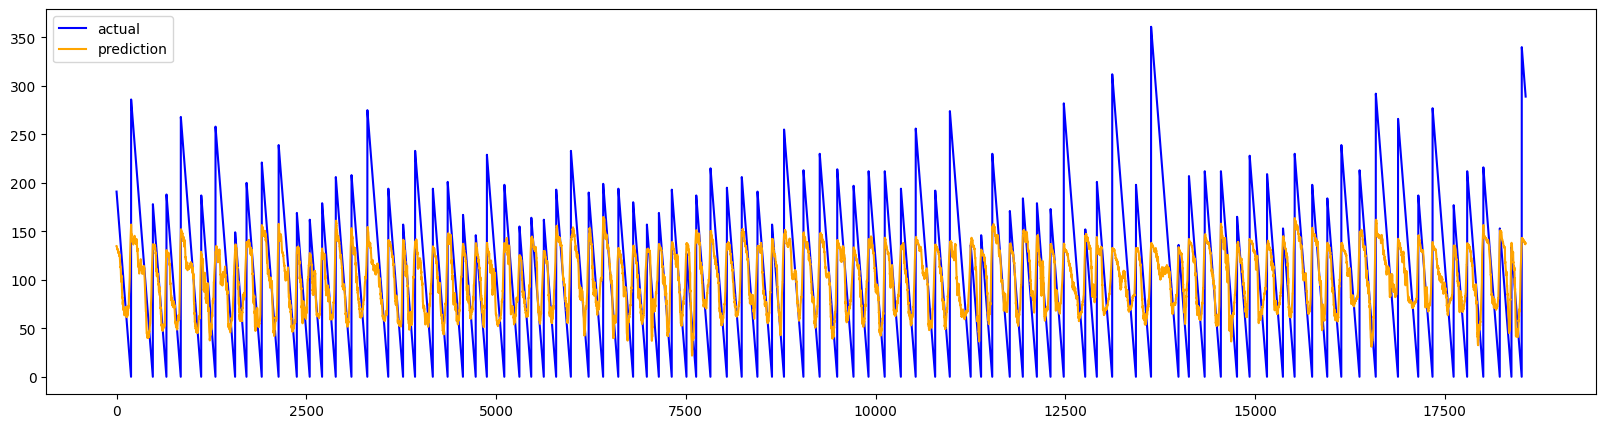

In [48]:
# y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader))
y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader,device= device, model_name= 'TDCNN'))
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

cnn

MSE: 3136.99
MAE: 42.09
r2 score: 0.31
MAPE: 237.00


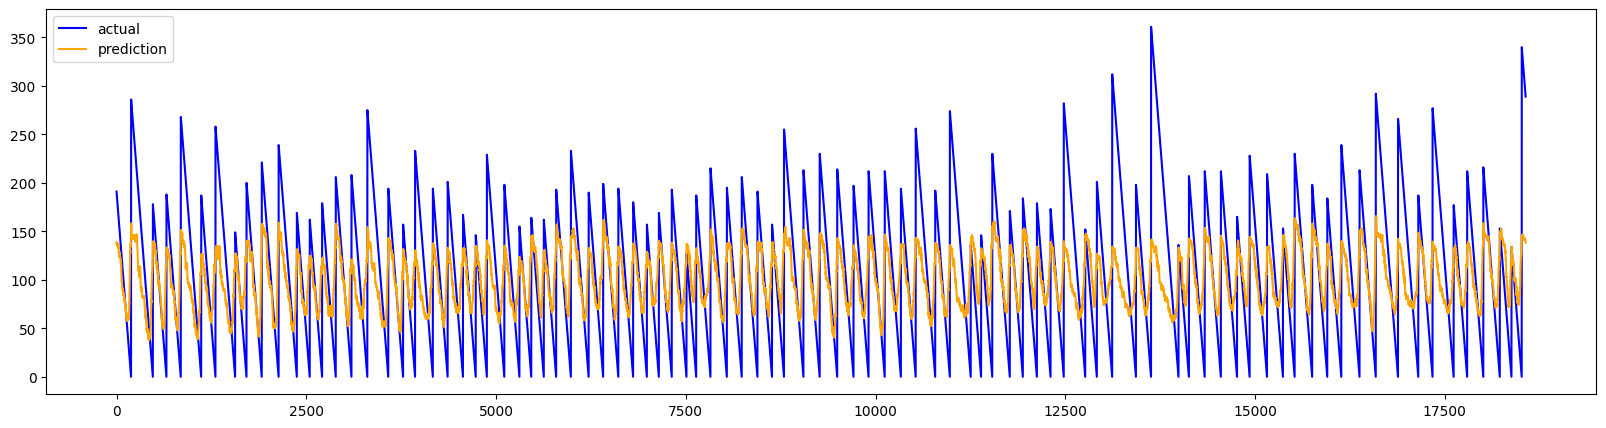

In [54]:
# y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader))
y_train_pred_inv = scaler_y.inverse_transform(predict(model, train_loader,device= device, model_name= 'TDCNN'))
y_train_inv = scaler_y.inverse_transform(y_train)
evaluate(y_train_inv, y_train_pred_inv)
plot_result(y_train_inv, y_train_pred_inv)

In [49]:
tr = pd.DataFrame(({'Actual': y_train_inv.flatten(), 'pred': y_train_pred_inv.flatten(), 'error': y_train_inv.flatten()-y_train_pred_inv.flatten()}))

tdcnn

   Actual        pred      error
0   191.0  134.885459  56.114541
1   190.0  134.953199  55.046801
2   189.0  134.749501  54.250499


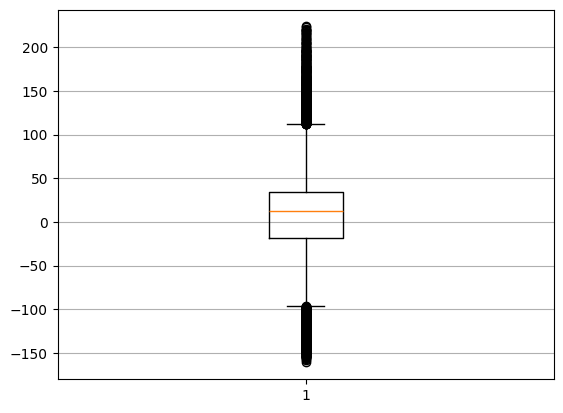

In [51]:
print(tr.head(3))
plt.boxplot(tr['error'])
plt.grid(axis='y')
plt.show()

cnn

In [58]:
tr

,Actual,pred,error
0,191.0,138.051241,52.948759
1,190.0,138.840010,51.159990
2,189.0,137.595937,51.404063
3,188.0,137.799105,50.200895
4,187.0,137.008719,49.991281
...,...,...,...
18562,293.0,140.552940,152.447060
18563,292.0,140.705793,151.294207
18564,291.0,139.723497,151.276503
18565,290.0,139.079912,150.920088


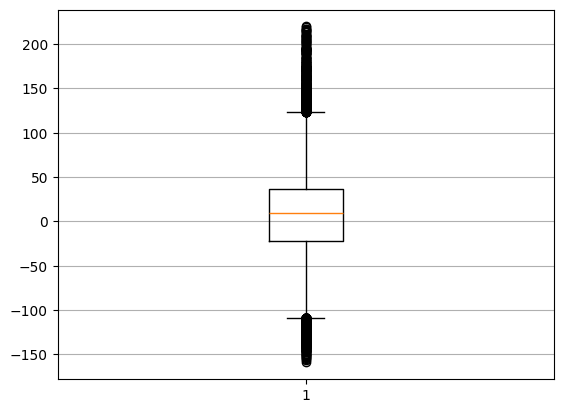

In [62]:
plt.boxplot(tr['error'], )
plt.grid(axis='y')
plt.show()

Linear regression

In [42]:
# model_lin_reg = LinearRegression()
# model_lin_reg.fit(x_train, y_train)

In [43]:
# y_pred_test_lin_reg = scaler_y.inverse_transform(model_lin_reg.predict(x_test))
# evaluate(y_test, y_pred_test_lin_reg)
# plot_result(y_test[:5000], y_pred_test_lin_reg[:5000])

In [44]:
# y_pred_train_lin_reg = scaler_y.inverse_transform(model_lin_reg.predict(x_train))
# y_train_ori = scaler_y.inverse_transform(y_train)
# evaluate(y_train_ori, y_pred_train_lin_reg)
# plot_result(y_train_ori[:5000], y_pred_train_lin_reg[:5000])

FPCA Implementation

In [57]:
import numpy as np
import skfda
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

In [58]:
# # Functional data object
# fd = skfda.FDataGrid(x_train)

# # Perform FPCA to reduce noise and extract principal components
# fpca = FPCA(n_components=4)  # Choose the number of components
# fpca.fit(fd)
# reconstructed_data = fpca.transform(fd)

In [59]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
pd.set_option('display.max_columns', None)
device

'cpu'

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.from_numpy(x_data).float()  # Convert numpy to tensor
        self.y_data = torch.from_numpy(y_data).float()

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [67]:
def create_seq(x, y):
    x_seq = []
    y_seq = []
    for i in range(len(x)-10):
        x_seq.append(x[i:i+10])
        y_seq.append(y[i+10])
    return x_seq, y_seq

In [70]:
x_train.shape, x_seq.shape

((18567, 26), (20611, 20, 26))

In [73]:
# x_seq, y_seq = create_seq(x_train, y_train)
# x_seq_test, y_seq_test = create_seq(x_test, y_test)

In [74]:
# train_dataset = TimeSeriesDataset(np.array(x_seq), np.array(y_seq))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataset = TimeSeriesDataset(np.array(x_seq_test), np.array(y_seq_test))
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [75]:
# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

In [76]:
for epoch in range(epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to the same device as the model
        inputs, targets = inputs.to(device), targets.to(device)
        # inputs = inputs.unsqueeze(2) 
        inputs = inputs.permute(0, 2, 1)
        # print(inputs.shape)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

c:\Users\priyjha\Documents\predictive_maintenance\new_env\Lib\site-packages\torch\nn\modules\conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\priyjha\Documents\predictive_maintenance\new_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\priyjha\Documents\predictive_maintenance\new_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (tor

Epoch [1/10], Loss: 34709.8164
Epoch [2/10], Loss: 34869.6719
Epoch [3/10], Loss: 32293.9805
Epoch [4/10], Loss: 31843.0820
Epoch [5/10], Loss: 27944.6504
Epoch [6/10], Loss: 29124.2441
Epoch [7/10], Loss: 27315.1250
Epoch [8/10], Loss: 27731.8652
Epoch [9/10], Loss: 25225.1582
Epoch [10/10], Loss: 23970.0645


In [41]:
torch.save(model.state_dict(), '../model/FPCASETCN_model_weights.pth')

In [77]:
def model_prediction(data_loader):
    y_pred_fptcn = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.permute(0, 2, 1)
            outputs = model(inputs)
            # y_pred_fptcn.append(outputs)
            y_pred_fptcn.extend(outputs.tolist())
    return y_pred_fptcn

In [78]:
y_pred_train_fptcn = model_prediction(train_loader)

In [79]:
y_pred_test_fptcn = model_prediction(test_loader)

MSE: 4336.40
MAE: 52.21
r2 score: 0.05
MAPE: 197.28


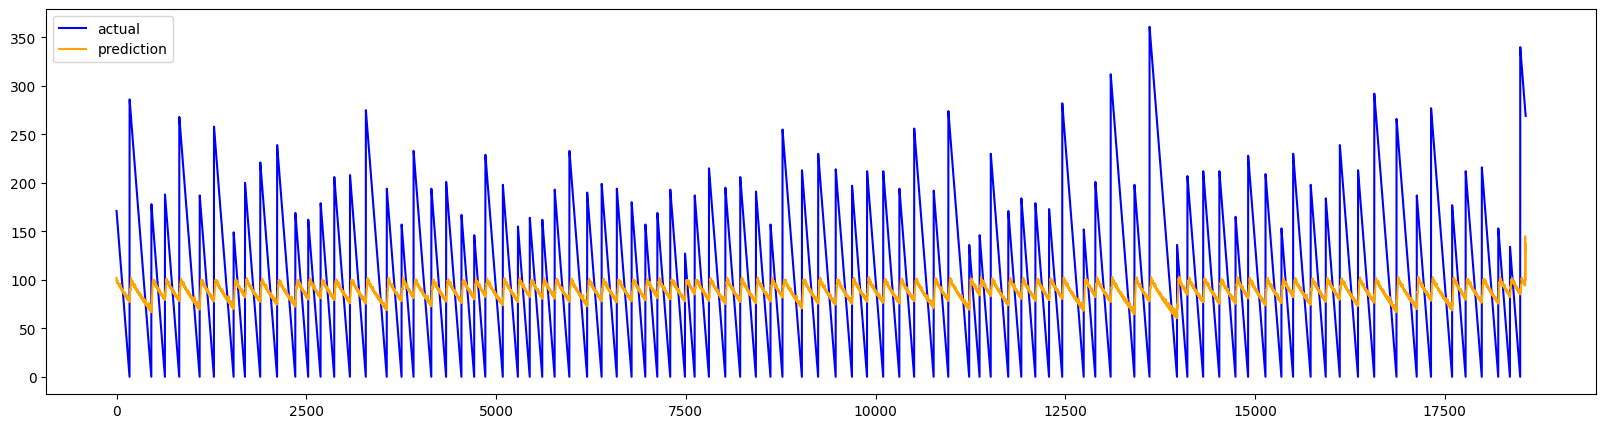

In [81]:
evaluate(y_train, y_pred_train_fptcn)
plot_result(y_train, y_pred_train_fptcn)

In [47]:
y_pred_train_fptcn = scaler_y.inverse_transform(y_pred_train_fptcn)
y_pred_test_fptcn = scaler_y.inverse_transform(y_pred_test_fptcn)

In [48]:
# y_pred_fptcn = [int(x) for x in y_pred_fptcn]

In [50]:
y_train_actual = scaler_y.inverse_transform(y_train).squeeze()[len(y_train) -len(y_pred_train_fptcn):]

In [ ]:
evaluate(y_train_actual, y_pred_train_fptcn)
plot_result(y_train_actual[:500], y_pred_train_fptcn[:500])

In [51]:
evaluate(y_train_actual, y_pred_train_fptcn)

MSE: 8762.87
MAE: 75.06
r2 score: -0.93
MAPE: 255.21


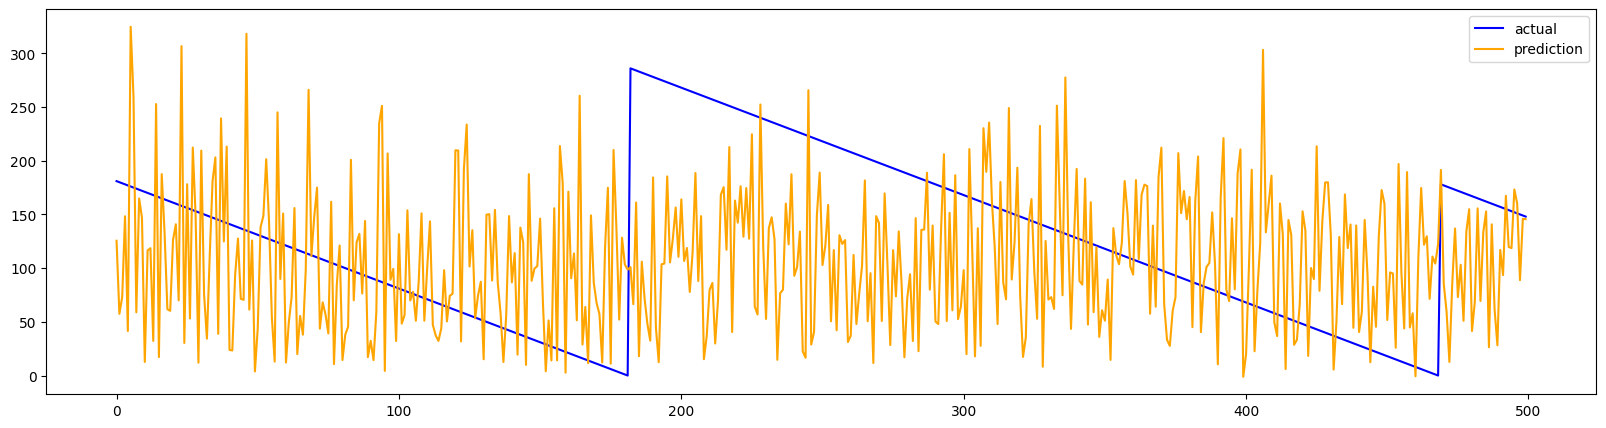

In [54]:
plot_result(y_train_actual[:500], y_pred_train_fptcn[:500])

In [60]:
df_err = pd.DataFrame({"actual": y_train_actual.squeeze(),
              "Pred": y_pred_train_fptcn.squeeze()})
df_err['error'] = df_err['actual'] - df_err['Pred']

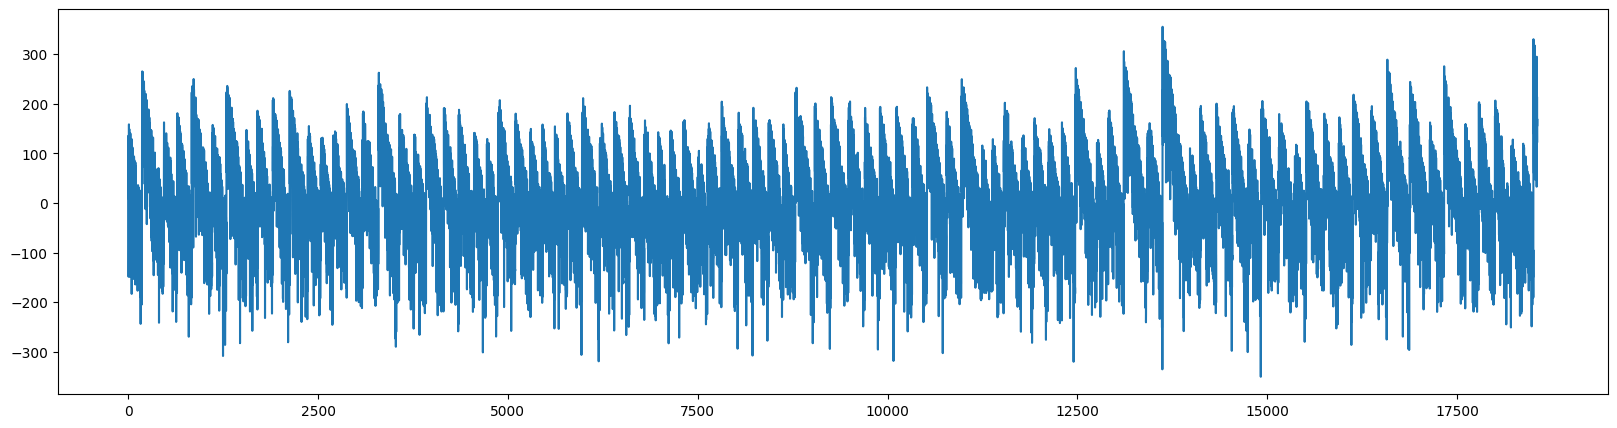

In [61]:
plt.figure(figsize=(20, 5))
plt.plot(df_err['error'])

In [64]:
len(y_test), len(y_pred_test_fptcn)

(13096, 13086)

MSE: 5849.82
MAE: 60.99
r2 score: -0.68
MAPE: 64.03


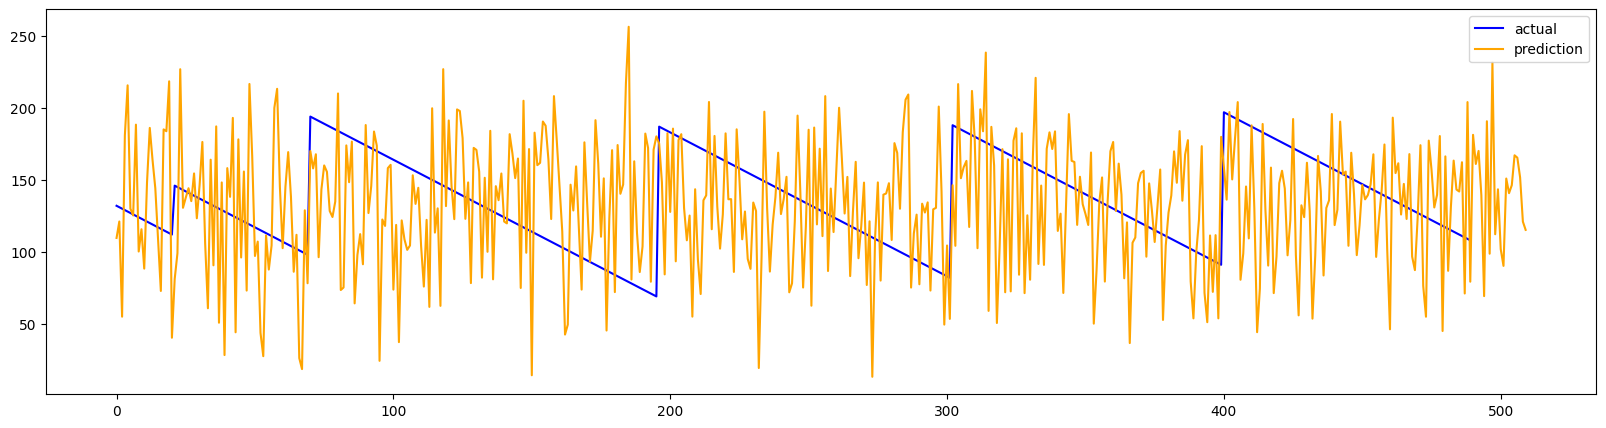

In [65]:
# y_test = scaler_y.inverse_transform(y_test).squeeze()[len(y_test) -len(y_pred_test_fptcn):]
evaluate(y_test[10:], y_pred_test_fptcn)
plot_result(y_test[10:500], y_pred_test_fptcn[:510])